# Práctica 3: Regresión Logística Multi-clase y Redes Neuronales

Mario Quiñones Pérez y Guillermo García Patiño Lenza

## Parte 1: Regresión logística multi-clase

### Visualización de los datos

En esta parte nos encargamos de crear dos funciones, la principal que usaremos en toda la práctica (cargaDatos), que servirá para cargar los datos del fichero 'ex3data1.mat' y devolver tanto la matriz de datos de los elementos de 20x20 pixeles (X) como el vector que representa el tipo de número que dichos pixeles representan (y). Aparte, crearemos una función que mostrará 10 elementos aleatorios de los 5000 que existen, función que solo sirve para mostrar que los datos se cargaron correctamente.

In [4]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

In [5]:
def cargaDatos(file = 'ex3data1.mat'):
    data = loadmat(file)
    y = data['y']
    X = data['X']
    return X,y

In [6]:
def verEjemplos():
    X,y = cargaDatos()
    ejs = np.random.choice(X.shape[0], 10)
    plt.imshow(X[ejs, :].reshape(-1,20).T)
    plt.axis('off')

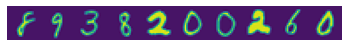

In [7]:
verEjemplos()

### Clasificación de uno frente a todos

#### Código de regresión logística de la práctica anterior

En esta parte de la práctica pondremos todo el código que será reutilizado de la práctica anterior de la parte de regresión logística.

Reutilizaremos las funciones básicas como sigmoide, que aplica la función sigmoide de un determinado elemento o grupo de elementos, la función de coste, que sirve para calcular el coste de que una theta cualquiera tiene sobre los datos de entrada en relación a las salidas esperadas dadas en 'y', y el gradiente que realiza el descenso de gradiente regularizado que sirve para calcular la theta óptima que reduce el coste al mínimo.

In [8]:
def sigmoide(Z):
    sigmoide = 1 / (1 + np.exp(-Z))
    return sigmoide

In [9]:
def coste(Theta, X, Y):
    G = sigmoide(np.dot(X, Theta))
    sum1 = np.dot(Y, np.log(G))
    sum2 = np.dot((1-Y), np.log(1 - G))
    return (-1 / X.shape[0]) * (sum1 + sum2)

In [10]:
def gradiente(Theta, X, Y):
    m = X.shape[0]
    G = sigmoide( np.matmul(X,Theta) )
    gradiente  = (1 / len(Y)) * np.matmul(X.T, G - Y)
    return gradiente

In [11]:
def coste_reg(Theta,X,Y, Lambda):
    c = coste(Theta,X,Y)
    m = X.shape[0]
    e = 0
    
    for t in range(1,len(Theta)):
        e += Theta[t]**2
        
    return c + (Lambda/(2*m))*e

In [12]:
def gradiente_reg(Theta,X,Y,Lambda):
    m = X.shape[0]
    gr = gradiente(Theta,X,Y)
    theta2 = (Lambda/m)*Theta
    return (gr + theta2)

In [13]:
def preparaFunciones(Lambda):
    c = lambda Theta,X,Y : coste_reg(Theta,X,Y,Lambda)
    gr = lambda Theta,X,Y : gradiente_reg(Theta,X,Y,Lambda)
    
    return (c,gr)

In [14]:

def prepara_datos(X, y, et):
   
    Y2 = (y == et) * 1
    ## Aquí hay que hacer ravel de Y2 para pasar de (5000,1) a (5000,1)
    ## y conseguir que funcione como en la practica anterior
    Y2 = np.ravel(Y2)
    return (X,Y2)

Además crearemos la función optimiza_reg() que utiliza la función scipy.optimize.fmin_tnc para calcular de forma eficiente el theta que reduce al mínimo el coste y haremos pruebas con dicha función

In [15]:
def optimiza_reg(X,Y,Lambda,et):
    X, Y= prepara_datos(X,Y,et)
    c, gr = preparaFunciones(Lambda)
    
    T = np.zeros(X.shape[1])

    result = opt.fmin_tnc(func = c, x0 = T, fprime = gr, args = (X, Y))
    c_f = coste(result[0], X, Y)
    print("coste:", c_f)
    return result[0]

In [20]:
def prueba2():
    X,Y = cargaDatos("ex3data1.mat")
    X, Y= prepara_datos(X,Y,0)
    Theta = np.zeros(X.shape[1])
    c = coste_reg(Theta,X,Y,1)
    gr = gradiente_reg(Theta,X,Y,1)
   
    print("Coste:", c)

In [21]:
prueba2()

Coste: 0.6931471805599466


#### Código de la práctica 3

En esta parte de la práctica utilizaremos las funciones definidas anteriormente para crear una función 'oneVsAll' que a partir de una 'X' y una 'y' , el número de distintas etiquetas que existen en dicha 'y' y un término de regularización dado, aplica el descenso de gradiente para calcular la theta óptima para cada uno de los distintos elementos representados en los datos y devuelve un array con todas estas Thetas que minimizan el coste de cada etiqueta.

In [40]:
def oneVsAll(X,y,num_etiquetas,reg):
    params = []
    
    # Por cada tipo de etiqueta se devuelve la Theta optima que reconoce la misma y se añade a un array de Thetas
    for et in range(num_etiquetas):
        p = optimiza_reg(X,y,reg,et)
        params.append(p)
    return np.array(params)

In [41]:
X,y = cargaDatos()
Theta = oneVsAll(X,y,10,0.1)

coste: 3.309827640039462e-05
coste: 0.008360021366380647
coste: 0.048193099008325836
coste: 0.06265130407015843
coste: 0.026607020319692778
coste: 0.04715622726021646
coste: 0.013260354391185423
coste: 0.025250802119906383
coste: 0.11250286209511665
coste: 0.07775397173239715


In [42]:
def evalua(file = 'ex3data1.mat'):
    X, y = cargaDatos()
    Theta = oneVsAll(X,y,10,0.1)
    asig = []
    for i in range(X.shape[0]) :
        l = np.dot(Theta, X[i])
        m = max(l)
        i = np.where(l == m)
        asig.append(i[0][0])
    
    y2 = np.ravel(y)
    t = (asig == y2)*1
    perc = (sum(t) / 5000) * 100
    print("Porcentaje de aciertos: ",perc , "%")

In [43]:
evalua()

coste: 3.309827640039462e-05
coste: 0.008360021366380647
coste: 0.048193099008325836
coste: 0.06265130407015843
coste: 0.026607020319692778
coste: 0.04715622726021646
coste: 0.013260354391185423
coste: 0.025250802119906383
coste: 0.11250286209511665
coste: 0.07775397173239715
Porcentaje de aciertos:  85.92 %


## Parte 2: Redes neuronales

En esta segunda parte utilizaremos una red neuronal ya entrenada para la correcta detección de los distintos dígitos posibles (0,1...9). Para ello utilizaremos las dos matrices theta1 y theta2 que son los pesos proporcionados para dicha red neuronal. Cada elemento pasará por tres capas o layers, dando como resultado diez neuronas en las que cada una se encargará de decidir como de parecido es con un número, la primera se activará cuando se reconoce un 1 y así sucesivamente hasta la décima activarse cuando reconozca un 0.

In [28]:
def prueba_neurona(datos, cargas):
    # Se cargan todos los datos necesarios para probar la neurona como sus pesos y los datos de prueba y entrenamiento (X e y)
    X = datos['X'] 
    Y = datos['y']
    n = len(y)
    theta1, theta2 = cargas['Theta1'], cargas['Theta2']
    
    # Se añade una fila de unos a la matriz inicial 
    X = np.hstack([np.ones([n,1]), X])
    
    # La capa oculta utiliza la primera matriz de pesos para crear sus neuronas y le añade una fila de unos
    Oculta = sigmoide(np.dot(X, theta1.T))
    Oculta = np.hstack([np.ones([n,1]), Oculta])
    
    # El resultado se calcula pasando por la segunda matriz de pesos todas las neuronas de la capa oculta
    Resultado = sigmoide(np.dot(Oculta, theta2.T))
    
    # Ya que cada neurona da un valor de como de parecido es el numero de prueba al número que esta se encarga de reconocer,
    # daremos prioridad a aquella neurona que reconozca con más exactitud dicho caso de prueba 
    comparador = np.argmax(Resultado, axis = 1)
    
    # Devolvemos el porcentaje de aciertos que la neurona a dado
    return (sum(comparador + 1 == np.ravel(y))/n*100)

In [29]:
percent = prueba_neurona(loadmat('ex3data1.mat'), loadmat('ex3weights.mat'))
print("Porcentaje de aciertos: ",percent , "%")

Porcentaje de aciertos:  97.52 %
